# Stock Prediction with Recurrent Neural Network

Deep learning is involved a lot in the modern quantitive financial field. There are many different neural networks can be applied to stock price prediction problems. The recurrent neural network, to be specific, the Long Short Term Memory(LSTM) network outperforms others architecture since it can take advantage of predicting time series (or sequentially) involved result with a specific configuration.

It is a really simple LSTM with Keras to predict the stock price in the Chinese stock.

In [2]:
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep

Using TensorFlow backend.


## Import Data

The csv file `chinese-stock-dataset.csv` is available in this repository.

In [3]:
df = pd.read_csv('/content/chinese-stock-dataset.csv')
df.head()

df.describe()

,open,high,low,volume,amount,close
count,5185.000000,5185.000000,5185.000000,5.185000e+03,5.185000e+03,5185.000000
mean,10.923111,11.158341,10.719549,5.674424e+07,7.089169e+08,10.939435
std,5.632976,5.802050,5.492728,8.436255e+07,1.258447e+09,5.647077
min,3.140000,3.200000,3.120000,3.210000e+04,1.073710e+05,3.140000
25%,7.370000,7.530000,7.240000,2.829651e+06,2.822304e+07,7.380000
50%,9.500000,9.680000,9.360000,2.493278e+07,2.058653e+08,9.500000
75%,13.270000,13.500000,13.020000,7.741890e+07,8.300743e+08,13.250000
max,39.000000,40.780000,38.210000,1.028373e+09,2.010649e+10,39.500000



## Preprocess Data

We can see from the table above that the scales of our features vary a lot. It will be beneficial to normalize the training data before feeding it into the model. 

"Having different features with widely different scales fed to the model will cause the network to weight the features unequally. This can cause a falsely prioritisation of some features over the others in the representation." Read [here](http://stackoverflow.com/a/43526354/6670143) for more detailed explanation.

In [0]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

## Splitting the data to X_train, y_train, X_test, y_test

In [0]:
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.values
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    
    train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

## Build the LSTM Network

Here we will build a simple RNN with 2 LSTM layers.
The architecture is:
    
    LSTM --> Dropout --> LSTM --> Dropout --> Fully-Conneted(Dense)

In [0]:
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [7]:
window = 20
X_train, y_train, X_test, y_test = preprocess_data(df[:: -1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (4648, 20, 6)
y_train (4648,)
X_test (516, 20, 6)
y_test (516,)


In [8]:
model = build_model([X_train.shape[2], window, 100, 1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 6), units=20)`
  


Compilation Time :  0.01978445053100586


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


## Training the Network

You can play with the hyperparameters here. The training process can take a significant time if you are using a average GPU or CPU(worse!).

In [9]:
model.fit(
    X_train,
    y_train,
    batch_size=768,
    epochs=5,
    validation_split=0.1,
    verbose=0)

In [10]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.05 MSE (0.21 RMSE)
Test Score: 0.18 MSE (0.42 RMSE)


## Visualize the Prediction

In [0]:
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

In [0]:
# TODO: Scale it back

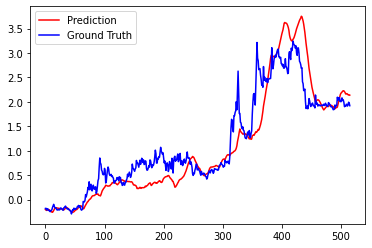

In [13]:
# if using within a jupyter notebook
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt2

plt2.plot(pred, color='red', label='Prediction')
plt2.plot(y_test, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()